# Vision

In [1]:
import wget
import os

if not os.path.exists("colour_mnist.py"):
    wget.download(
        "https://raw.githubusercontent.com/clovaai/rebias/master/datasets/colour_mnist.py",
        "colour_mnist.py",
    )

if not os.path.exists("flac.py"):
    wget.download(
        "https://raw.githubusercontent.com/gsarridis/FLAC/main/flac.py", "flac.py"
    )

100% [................................................................................] 1798 / 1798

In [2]:
from colour_mnist import get_biased_mnist_dataloader

trainloader = get_biased_mnist_dataloader(
    root="./data", batch_size=128, data_label_correlation=0.99, train=True
)
testloader = get_biased_mnist_dataloader(
    root="./data", batch_size=128, data_label_correlation=0.1, train=False
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\raw\train-images-idx3-ubyte.gz to ./data\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\raw\train-labels-idx1-ubyte.gz to ./data\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\raw\t10k-images-idx3-ubyte.gz to ./data\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\raw\t10k-labels-idx1-ubyte.gz to ./data\raw



### What data look like

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

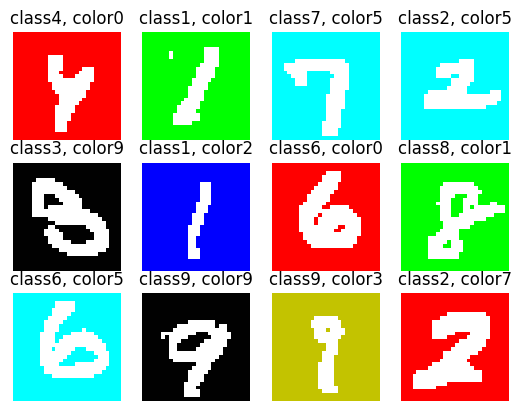

In [3]:
images, labels, sensitive = next(testloader.__iter__())
import matplotlib.pyplot as plt

for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[i, :].permute(1, 2, 0))
    plt.axis("off")
    plt.title(f"class{labels[i]}, color{sensitive[i]}")

### Define architecture and its training
To run the flac (the fairness-aware regularization) approach, you need the architecture to output (predictions, features).

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        ## https://github.com/gsarridis/FLAC/blob/main/models/simple_conv.py
        super().__init__()
        dims = 6
        self.conv1 = nn.Conv2d(3, dims, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(dims, 16, 5)
        self.fc = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  ## flatten all dimensions except batch
        x = F.normalize(x, dim=1)
        features = x
        x = self.fc(x)
        return x, features

In [4]:
import flac

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


def train(trainloader, net, colornet=None, reg=100, epochs=5, classpos=1, senspos=2):
    lossfunc = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    if colornet is not None:
        colornet.eval()
    for epoch in range(epochs):
        epoch_loss = 0
        batches = 0
        for data in trainloader:
            optimizer.zero_grad()
            inputs, labels, sensitive = (
                data[0].to(device),
                data[classpos].to(device),
                data[senspos].to(device),
            )
            outputs, features = net(inputs)
            loss = lossfunc(outputs, labels)
            if colornet is not None:
                with torch.no_grad():
                    _, colorfeats = colornet(inputs)
                loss += reg * flac.flac_loss(
                    colorfeats, features, torch.squeeze(labels)
                )
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            batches += 1
            print(f"\r[{epoch + 1}] loss: {epoch_loss/batches:.3f}", end="")
    print("\nFinished training")

cuda:0


### Train the architecture

In [5]:
net = Net()
net.to(device)
train(trainloader, net)
torch.save(net.state_dict(), "./data/model.pth")

[5] loss: 0.077
Finished training


### Train the fair architecture
This first needs to train a classifier `colornet` that predicts the sensitive attribute (classpos=2 in the dataloader). The classifier's embeddings, i.e., the outputted features, are used to make training more fair for the actual `fairnet` classifer. The latter will be fairer *without* needing to observe the sensitive attribute in its inputs.

In [6]:
colornet = Net()
colornet.to(device)
train(trainloader, net=colornet, classpos=2, epochs=1)

fairnet = Net()
fairnet.to(device)
train(trainloader, fairnet, colornet)
torch.save(fairnet.state_dict(), "./data/fair_model.pth")

[1] loss: 0.876
Finished training
[5] loss: 0.387
Finished training


### Evaluation
First keep track of predictions per class and concatenate them across batches. Then use reporting to make a comparison.

In [7]:
import fairbench as fb

fb.setbackend("torch")


def evaluate(net):
    nclasses = 10
    nsensitive = 10
    vals = {f"class{c}": None for c in range(nclasses)}
    with torch.no_grad():
        for data in testloader:
            images, labels, sensitive = data
            outs, _ = net(images)
            _, predictions = torch.max(outs, 1)
            sensitive = fb.Fork(color=fb.Categories(range(nsensitive)) @ sensitive)
            for c in range(nclasses):
                cname = f"class{c}"
                vals[cname] = fb.concatenate(
                    vals.get(cname, None),
                    fb.todict(
                        predictions=(predictions == c).float(),
                        labels=(labels == c).float(),
                        sensitive=sensitive,
                    ),
                )
    return vals

In [8]:
net = Net()
net.load_state_dict(torch.load("./data/model.pth"))
net.eval()
vals = evaluate(net)

In [9]:
fairnet = Net()
fairnet.load_state_dict(torch.load("./data/fair_model.pth"))
fairnet.eval()
fairvals = evaluate(fairnet)

In [10]:
report = fb.multireport(fb.Fork(vals))
fairreport = fb.multireport(fb.Fork(fairvals))

comparison = fb.Fork(net=report, fair_net=fairreport)
fb.extract(accuracy=comparison.min.accuracy, prule=comparison.minratio.pr)

accuracy,"class1: PyTorchTensor(tensor(0.2273, dtype=torch.float64)) class4: PyTorchTensor(tensor(0.1316, dtype=torch.float64)) class5: PyTorchTensor(tensor(0.0887, dtype=torch.float64)) class8: PyTorchTensor(tensor(0.0967, dtype=torch.float64)) class7: PyTorchTensor(tensor(0.1021, dtype=torch.float64)) class3: PyTorchTensor(tensor(0.1014, dtype=torch.float64)) class0: PyTorchTensor(tensor(0.0981, dtype=torch.float64)) class9: PyTorchTensor(tensor(0.0997, dtype=torch.float64)) class2: PyTorchTensor(tensor(0.1028, dtype=torch.float64)) class6: PyTorchTensor(tensor(0.1466, dtype=torch.float64))"
prule,"class1: PyTorchTensor(tensor(0., dtype=torch.float64)) class4: PyTorchTensor(tensor(0., dtype=torch.float64)) class5: PyTorchTensor(tensor(0., dtype=torch.float64)) class8: PyTorchTensor(tensor(0., dtype=torch.float64)) class7: PyTorchTensor(tensor(0., dtype=torch.float64)) class3: PyTorchTensor(tensor(0., dtype=torch.float64)) class0: PyTorchTensor(tensor(0., dtype=torch.float64)) class9: PyTorchTensor(tensor(0., dtype=torch.float64)) class2: PyTorchTensor(tensor(0., dtype=torch.float64)) class6: PyTorchTensor(tensor(0., dtype=torch.float64))"
accuracy,"class1: PyTorchTensor(tensor(0.7587, dtype=torch.float64)) class4: PyTorchTensor(tensor(0.6072, dtype=torch.float64)) class5: PyTorchTensor(tensor(0.3679, dtype=torch.float64)) class8: PyTorchTensor(tensor(0.5174, dtype=torch.float64)) class7: PyTorchTensor(tensor(0.5676, dtype=torch.float64)) class3: PyTorchTensor(tensor(0.2751, dtype=torch.float64)) class0: PyTorchTensor(tensor(0.6727, dtype=torch.float64)) class9: PyTorchTensor(tensor(0.1964, dtype=torch.float64)) class2: PyTorchTensor(tensor(0.5858, dtype=torch.float64)) class6: PyTorchTensor(tensor(0.6704, dtype=torch.float64))"
prule,"class1: PyTorchTensor(tensor(0., dtype=torch.float64)) class4: PyTorchTensor(tensor(0., dtype=torch.float64)) class5: PyTorchTensor(tensor(0., dtype=torch.float64)) class8: PyTorchTensor(tensor(0., dtype=torch.float64)) class7: PyTorchTensor(tensor(0., dtype=torch.float64)) class3: PyTorchTensor(tensor(0., dtype=torch.float64)) class0: PyTorchTensor(tensor(0., dtype=torch.float64)) class9: PyTorchTensor(tensor(0., dtype=torch.float64)) class2: PyTorchTensor(tensor(0., dtype=torch.float64)) class6: PyTorchTensor(tensor(0., dtype=torch.float64))"


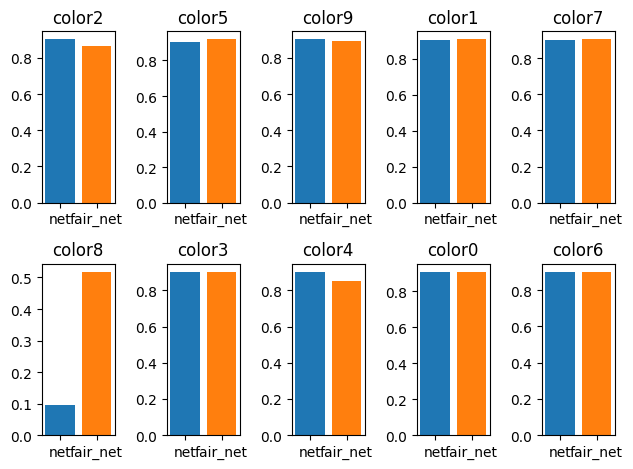

In [11]:
fb.visualize(comparison.min.class8.accuracy.explain)  ## visualize an explanation

### Explain  a prediction
Negatives have high accuracy, which indicates small false negative rate for each class. You should look at the accuracy.

In [20]:
comparison.class3.net.minratio.pr.explain

color2,0.0
color5,0.0
color9,0.0
color1,0.0
color7,0.0
color8,0.0
color3,1.0
color4,0.0
color0,0.0
color6,0.0
